In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import Model
#from tensorflow.train import exponential_decay

In [2]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [3]:
y_test = y_test - 769
y_train_valid = y_train_valid - 769
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [4]:
# 把最后一个axis变两倍， 500 -> 1000
def double_ax2(a):
    result = np.zeros((a.shape[0],a.shape[1],a.shape[2] * 2))
    b = np.reshape(a[:,:,-1],(a.shape[0],a.shape[1],1))
    aMod = np.concatenate((a,b),axis = 2)
    for i in range(a.shape[2]):
        ave = (aMod[:,:,i] + aMod[:,:,i+1]) / 2
        result[:,:,2 * i] = aMod[:,:,i]
        result[:,:,2*i + 1] = ave
    return result

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid,
                                                      test_size=0.2,shuffle=True,
                                                      stratify=y_train_valid)
#X_train = X_train.transpose(0,2,1)  # no need to transpose if downsampling
#X_valid = X_valid.transpose(0,2,1)
#X_test = X_test.transpose(0,2,1)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(1692, 22, 1000)
(423, 22, 1000)
(443, 22, 1000)


(array([106.,   0.,   0., 102.,   0.,   0., 109.,   0.,   0., 106.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

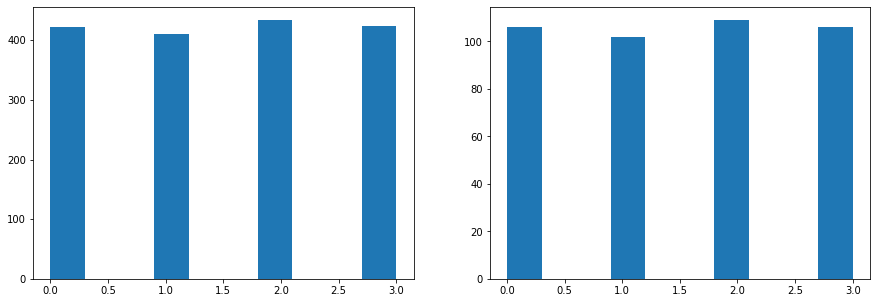

In [6]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(y_train)
plt.subplot(1, 2, 2)
plt.hist(y_valid)

In [7]:
# downsample ########
num_time = X_train.shape[2]
sample_1 = list(np.arange(0,num_time,2))
sample_2 = list(np.arange(1,num_time,2))

X_train_1 = X_train[:,:,sample_1]
X_train_2 = X_train[:,:,sample_2]

X_val_1 = X_valid[:,:,sample_1]
X_val_2 = X_valid[:,:,sample_2]

X_test_s1 = X_test[:,:,sample_1]
X_test_s2 = X_test[:,:,sample_2]

X_train_s = np.concatenate((X_train_1,X_train_2), axis=0).transpose(0, 2, 1)
#X_train_s = double_ax2(X_train_s_).transpose(0, 2, 1)  # upsampling
y_train_s = np.concatenate((y_train,y_train), axis=0)

X_valid_s = X_val_1.transpose(0, 2, 1)
#X_val_s = X_valid.transpose(0, 2, 1)  # upsampling
y_valid_s = y_valid

X_test_s = X_test_s1.transpose(0, 2, 1)
#X_test_s = X_test_1.transpose(0, 2, 1) # upsampling
y_test_s = y_test

print(X_train_s.shape)
print(y_train_s.shape)
print(X_valid_s.shape)
print(X_test_s.shape)

(3384, 500, 22)
(3384,)
(423, 500, 22)
(443, 500, 22)


In [8]:
from tensorflow.keras import regularizers

In [9]:
hidden_gru = 64

In [10]:
l1_reg = regularizers.l1(0.00005)
l2_reg = regularizers.l2(0.01)
l1_l2 = regularizers.l1_l2(l1=0.0005, l2=0.01)

In [11]:
gru_net_input = layers.Input(shape=(500,22))
#gru_net_input = layers.Input(shape=(22,1000))
#x = layers.UpSampling1D(size=2)(gru_net_input)

x = layers.Conv1D(128, 9, strides=1, padding='valid', kernel_regularizer=l1_l2)(gru_net_input)
x = layers.BatchNormalization(axis=-1)(x)
x = layers.ELU(alpha=1)(x)
#x = layers.SpatialDropout1D(0.2)(x)
out_max = layers.MaxPooling1D(pool_size=2)(x)

#x = layers.Conv1D(248, 5, strides=1, padding='valid', kernel_regularizer=l1_l2, data_format='channels_first')(out_max)
#x = layers.BatchNormalization(axis=-1)(x)
#out_max = layers.ELU(alpha=1)(x)
#x = layers.SpatialDropout1D(0.2)(x)
#x = layers.Add()([x, out_max])
#out_max = layers.MaxPooling1D(pool_size=2)(x)

#gru_f = layers.GRU(40,return_sequences=True, kernel_regularizer=l1_l2)(gru_net_input) # hidden_dims of gru = 40
#gru_b = layers.GRU(40,return_sequences=True, kernel_regularizer=l1_l2, go_backwards=True)(gru_net_input)
#gru = layers.Concatenate(axis=-1)([gru_f, gru_b])

#gru_f = layers.GRU(40,return_sequences=True, kernel_regularizer=l1_l2)(gru) # hidden_dims of gru = 40
#gru_b = layers.GRU(40,return_sequences=True, kernel_regularizer=l1_l2, go_backwards=True)(gru)
#gru = layers.Concatenate(axis=-1)([gru_f, gru_b])  activity_regularizer=l1_reg

lstm = layers.LSTM(128,return_sequences=True, kernel_regularizer=l1_l2)(out_max)
#gru = layers.LSTM(64,return_sequences=True, kernel_regularizer=l1_l2)(gru)

lstm = layers.Add()([lstm, out_max])

x = layers.Conv1D(128, 9, strides=1, padding='valid', kernel_regularizer=l1_l2)(lstm)
x = layers.BatchNormalization(axis=-1)(x) # output batch*500*64
x = keras.layers.ZeroPadding1D(padding=(0, 1))(x) # for downsample data and 9 kernel size
#x = layers.ReLU()(x)
x = layers.ELU(alpha=1)(x)
#x = layers.SpatialDropout1D(0.2)(x)
x = layers.MaxPooling1D(pool_size=2)(x)

x = layers.Conv1D(128, 9, strides=1, padding='valid', kernel_regularizer=l1_l2)(x)
x = layers.BatchNormalization(axis=-1)(x) # output batch*500*124
x = keras.layers.ZeroPadding1D(padding=(0, 1))(x) # for downsample data
#x = layers.ReLU()(x)
x = layers.ELU(alpha=1)(x)
#x = layers.SpatialDropout1D(0.2)(x)
x = layers.MaxPooling1D(pool_size=2)(x)

x = layers.Reshape((int(56*128),))(x) # 125*128 for full shape data. 59*128 for downsample data

x = layers.Dense(300, kernel_regularizer=l1_l2)(x) # output batch*64*64  the last dimension is sequence
x = layers.BatchNormalization(axis=-1)(x) # after permute to axis=1
x = layers.ELU(alpha=1)(x)
#x = layers.ReLU()(x)
x = layers.Dropout(0.8)(x)

x = layers.Dense(40, kernel_regularizer=l1_l2)(x) # output batch*64*64  the last dimension is sequence
x = layers.BatchNormalization(axis=-1)(x) # after permute to axis=1
x = layers.ELU(alpha=1)(x)
#x = layers.ReLU()(x)
x = layers.Dropout(0.8)(x)

output = layers.Dense(4, activation='softmax', kernel_regularizer=l1_l2)(x)

model_ = keras.Model(gru_net_input, output)
model_.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500, 22)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 492, 128)     25472       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 492, 128)     512         conv1d[0][0]                     
__________________________________________________________________________________________________
elu (ELU)                       (None, 492, 128)     0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
loss_ = keras.losses.SparseCategoricalCrossentropy()
#optim = keras.optimizers.Adam(learning_rate=0.0005)
optim = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True, name='SGD')
model_.compile(optimizer=optim, loss=loss_, metrics=['accuracy'])

In [13]:
loss_hist = model_.fit(X_train_s, y_train_s, epochs=120,
                       batch_size=282, validation_data=(X_valid_s, y_valid_s))

Train on 3384 samples, validate on 423 samples
Epoch 1/120
3384/3384 [==============================] - 6s 2ms/sample - loss: 35.5656 - accuracy: 0.2533 - val_loss: 34.5550 - val_accuracy: 0.2600
Epoch 2/120
3384/3384 [==============================] - 2s 487us/sample - loss: 35.1864 - accuracy: 0.2722 - val_loss: 34.4612 - val_accuracy: 0.3239
Epoch 3/120
3384/3384 [==============================] - 2s 485us/sample - loss: 34.8398 - accuracy: 0.2769 - val_loss: 34.1008 - val_accuracy: 0.3428
Epoch 4/120
3384/3384 [==============================] - 2s 486us/sample - loss: 34.3658 - accuracy: 0.3112 - val_loss: 33.7418 - val_accuracy: 0.3428
Epoch 5/120
3384/3384 [==============================] - 2s 488us/sample - loss: 34.1359 - accuracy: 0.3070 - val_loss: 33.4634 - val_accuracy: 0.3546
Epoch 6/120
3384/3384 [==============================] - 2s 488us/sample - loss: 33.7729 - accuracy: 0.3227 - val_loss: 33.1894 - val_accuracy: 0.3546
Epoch 7/120
3384/3384 [==========================

3384/3384 [==============================] - 2s 490us/sample - loss: 23.6727 - accuracy: 0.6025 - val_loss: 23.6969 - val_accuracy: 0.5721
Epoch 52/120
3384/3384 [==============================] - 2s 492us/sample - loss: 23.4847 - accuracy: 0.6061 - val_loss: 23.5137 - val_accuracy: 0.5721
Epoch 53/120
3384/3384 [==============================] - 2s 492us/sample - loss: 23.3238 - accuracy: 0.5922 - val_loss: 23.3387 - val_accuracy: 0.5626
Epoch 54/120
3384/3384 [==============================] - 2s 490us/sample - loss: 23.1119 - accuracy: 0.6244 - val_loss: 23.1646 - val_accuracy: 0.5697
Epoch 55/120
3384/3384 [==============================] - 2s 492us/sample - loss: 22.9559 - accuracy: 0.6087 - val_loss: 22.9859 - val_accuracy: 0.5697
Epoch 56/120
3384/3384 [==============================] - 2s 492us/sample - loss: 22.7696 - accuracy: 0.6155 - val_loss: 22.8097 - val_accuracy: 0.5863
Epoch 57/120
3384/3384 [==============================] - 2s 488us/sample - loss: 22.5961 - accuracy:

Epoch 105/120
3384/3384 [==============================] - 2s 495us/sample - loss: 14.9802 - accuracy: 0.8522 - val_loss: 15.4172 - val_accuracy: 0.6028
Epoch 106/120
3384/3384 [==============================] - 2s 491us/sample - loss: 14.8373 - accuracy: 0.8605 - val_loss: 15.2899 - val_accuracy: 0.6076
Epoch 107/120
3384/3384 [==============================] - 2s 494us/sample - loss: 14.7146 - accuracy: 0.8579 - val_loss: 15.1544 - val_accuracy: 0.6147
Epoch 108/120
3384/3384 [==============================] - 2s 497us/sample - loss: 14.5836 - accuracy: 0.8561 - val_loss: 15.0262 - val_accuracy: 0.6147
Epoch 109/120
3384/3384 [==============================] - 2s 492us/sample - loss: 14.4317 - accuracy: 0.8735 - val_loss: 14.8887 - val_accuracy: 0.6383
Epoch 110/120
3384/3384 [==============================] - 2s 496us/sample - loss: 14.2935 - accuracy: 0.8797 - val_loss: 14.7862 - val_accuracy: 0.6147
Epoch 111/120
3384/3384 [==============================] - 2s 495us/sample - loss:

In [14]:
hist = loss_hist.history
list(hist)

['loss', 'accuracy', 'val_loss', 'val_accuracy']

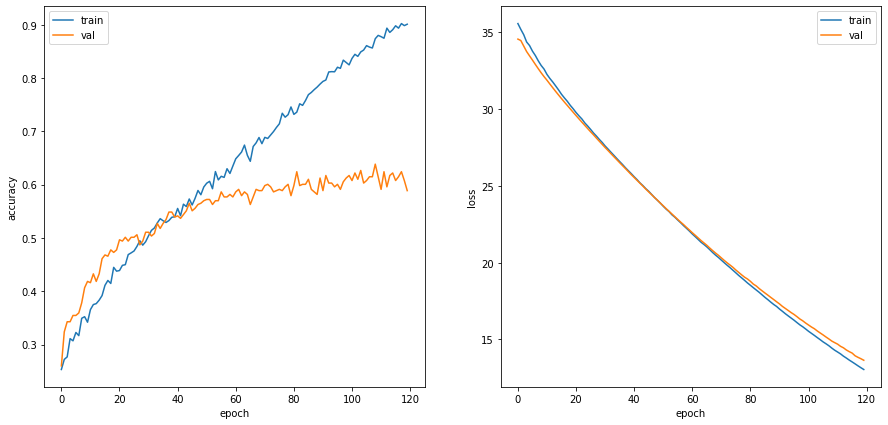

In [15]:

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

plt.subplot(1, 2, 2)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

In [16]:
val_results = model_.evaluate(x=X_valid_s, y=y_valid_s, batch_size=16, verbose=2)
print(['val loss, val acc', val_results])

423/1 - 0s - loss: 13.7543 - accuracy: 0.5887
['val loss, val acc', [13.639750446833617, 0.5886525]]


In [17]:
test_results = model_.evaluate(x=X_test_s, y=y_test_s, batch_size=50, verbose=2)
print(['test loss, test acc', test_results])

443/1 - 0s - loss: 13.5885 - accuracy: 0.6163
['test loss, test acc', [13.635794641740166, 0.61625284]]


In [ ]:
#GRUnet = tf.keras.Sequential()
GRUnet.add(layers.Conv1D(64, 3, strides=1, padding='valid',
                         activation='relu', activity_regularizer=regularizers.l1(0.0005)))
GRUnet.add(layers.MaxPooling1D(pool_size=2))
GRUnet.add(layers.GRU(40,activity_regularizer=regularizers.l1(0.0005),
                      dropout=0, recurrent_dropout=0.0,return_sequences=True, return_state=True))

In [ ]:
##### with l1_norm
gru_net_input = layers.Input(shape=(500,22))

#x = layers.UpSampling1D(size=2)(gru_net_input)

#x = layers.SpatialDropout1D(0.2)(gru_net_input)

#x = layers.Conv1D(64, 3, strides=1, padding='valid',activation='relu')(x)
#x = layers.BatchNormalization(axis=-1)(x)
#x = layers.MaxPooling1D(pool_size=2)(x)
#x = layers.SpatialDropout1D(0.2)(x)

gru, final_state = layers.GRU(40,return_sequences=True,
                              return_state=True,
                              kernel_regularizer=regularizers.l1(0.0005),
                              bias_regularizer=regularizers.l1(0.0005))(gru_net_input) # hidden_dims of gru = 40
#gru = layers.GRU(256)(x) # hidden_dims of gru = 64

x = layers.Conv1D(64, 3, strides=1, padding='same',
                  kernel_regularizer=regularizers.l1(0.0005),
                  bias_regularizer=regularizers.l1(0.0005))(gru)
x = layers.BatchNormalization(axis=-1)(x) # output batch*500*124
#x = layers.ReLU()(x)
x = layers.ELU(alpha=1)(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.SpatialDropout1D(0.5)(x)

x = layers.Conv1D(64, 3, strides=1, padding='same',
                  kernel_regularizer=regularizers.l1(0.0005),
                  bias_regularizer=regularizers.l1(0.0005))(x)
x = layers.BatchNormalization(axis=-1)(x) # output batch*500*124
#x = layers.ReLU()(x)
x = layers.ELU(alpha=1)(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.SpatialDropout1D(0.5)(x)

x = layers.Reshape((int(125*64),))(x)

x = layers.Dense(300,kernel_regularizer=regularizers.l1(0.0005),
                 bias_regularizer=regularizers.l1(0.0005))(x) # output batch*64*64  the last dimension is sequence
x = layers.BatchNormalization(axis=-1)(x) # after permute to axis=1
x = layers.ELU(alpha=1)(x)
#x = layers.ReLU()(x)
x = layers.Dropout(0.8)(x)

x = layers.Dense(40,kernel_regularizer=regularizers.l1(0.0005),
                 bias_regularizer=regularizers.l1(0.0005))(x) # output batch*64*64  the last dimension is sequence
x = layers.BatchNormalization(axis=-1)(x) # after permute to axis=1
x = layers.ELU(alpha=1)(x)
#x = layers.ReLU()(x)
x = layers.Dropout(0.8)(x)

output = layers.Dense(4, activation='softmax',
                      kernel_regularizer=regularizers.l1(0.0005),
                      bias_regularizer=regularizers.l1(0.0005))(x)

model_ = keras.Model(gru_net_input, output)
model_.summary()


In [ ]:
gru_net_input = layers.Input(shape=(500,22))

x = layers.SpatialDropout1D(0.2)(gru_net_input)
x = layers.Conv1D(64, 3, strides=1, padding='valid',
                  activation='relu')(x)
x = layers.BatchNormalization(axis=-1)(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Dropout(0.5)(x)

#gru, final_state = layers.GRU(124,return_sequences=True, return_state=True)(x) # hidden_dims of gru = 64
gru = layers.GRU(256,return_sequences=True, return_state=True)(x) # hidden_dims of gru = 64

#x = layers.Conv1D(64, 3, strides=1, padding='same',activation='relu')(gru_out)
x = layers.BatchNormalization(axis=-1)(gru) # output batch*249*64
#x = layers.MaxPooling1D(pool_size=2)(x)

#x = layers.Permute((2,1))(x)
x = layers.Dense(64, activation='relu')(x) # output batch*64*64  the last dimension is sequence
x = layers.BatchNormalization(axis=1)(x) # after permute to axis=1
#x = layers.Permute((2,1))(x)
x = layers.Dropout(0.8)(x)

#x = layers.Reshape((int(124*64),))(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization(axis=-1)(x)
x = layers.Dropout(0.8)(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization(axis=-1)(x)
x = layers.Dropout(0.8)(x)

output = layers.Dense(4, activation='softmax')(x)

model = keras.Model(gru_net_input, output)
model.summary()
